# Train and evaluate model

This notebook is a 3d analogue to train_and_eval.ipynb. We train a basic CNN encoder from scratch on a dataset of sparse 3d polynomials. We then evaluate reconstruction performance on two systems, one simple (a 3d saddle node family) and one more complex (the Lorenz model). 

Our coding framework is based on a Click interface and we make use of that in this notebook by running the basic steps in the pipeline through shell commands. 


In [1]:
import os
import subprocess
from phase2vec.utils import get_command_defaults, ensure_dir, write_yaml, update_yaml
from phase2vec.train import load_model, train_model, run_epoch
from phase2vec.data import load_dataset, SystemFamily
import pdb

## Generate data
First, we generate both the training and testing sets. The former will be a set of vector fields corresponding to polynomial ODEs of degree at most 3 and having sparse coefficients. The testing set will be vector fields representing the flows of 10 types of sytsems drawn from across the sciences. In all cases, we work with planar (i.e. two-dimensional systems). 

First, we set some basic parameters, including the types of training and testing data and the number of their samples. 

In [2]:
## Generate data

data_dir = '../data' # Alter to change where all of the phase2vec data will be saved. 

# Edit the data included in training and testing here. 
train_data_names = ['polynomial']
poly_order=3
test_data_names  = ['lorenz','saddle_node_3d']

# test_data_names  = ['lotka_volterra']
train_system_classes = []
test_system_classes = []
for n, names in enumerate([train_data_names, test_data_names]):
    for system in [SystemFamily(data_name=name,poly_order=poly_order) for name in names]:
        if n == 0:
            train_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]
        else:
            test_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]

num_train_classes = len(train_system_classes)
num_test_classes = len(test_system_classes)

# Edit the number of total samples from each data set here.
#By default, each set is divied further into a base and validation set at a 75/100 split. This can be altered below. 
num_train_samples = 10000 # total number of train/val samples
num_test_samples  = 1000 # total number of test samples. Note these are split themselves automatically into a regular and a validation component, but they can be combined. 
device            = 'cuda' # set to `cpu` if cuda not available
num_lattice       = 32

# Leave this untouched unless you want to change how parameters from each system are sampled and the proportions of each system in the data set.
test_samplers    = ['uniform'] * len(test_data_names)
test_props       = [str(1. / len(test_data_names))] * len(test_data_names)
test_data_names   = '-s ' +  ' -s '.join(test_data_names)
test_samplers     = '-sp ' +  ' -sp '.join(test_samplers)
test_props = '-c ' +  ' -c '.join(test_props)
test_mis   = '-mi -1 -mi -1 -mi -1'
test_mas   = '-ma 1 -ma 1 -ma 1'

Next, we call the actual shell commands for generating the data. These commands will make two directories, called `polynomial` and `classical`, corresponding to train and test sets, inside your `data_dir`. 

In order to alter the validation proportion, $p$, add the flag `--val-size <p>` where $p\in (0,1)$. 

In [3]:
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name 3d_test --num-lattice {num_lattice} --num-samples {num_test_samples} {test_data_names} {test_samplers} {test_props} {test_mis} {test_mas}', shell=True)

Generating lorenz data.
Generating saddle_node_3d data.


0

For the training data, we make sure to include the path to the forms for the testing data so that forms are not duplicated.

In [3]:
holdout_fn = os.path.join(data_dir, '3d_test', 'forms.npy')
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --num-lattice {num_lattice} --num-samples {num_train_samples} --data-set-name polynomial_3d --system-names {train_data_names[0]} -sp control -h {holdout_fn} {test_mis} {test_mas}', shell=True)

Generating polynomial data.


0

## Instantiate `phase2vec` encoder. 

We build the embedding CNN. We use the default parameters which we access by fetching the default arguments from the click command `generate_net_config`. To edit these parameters, alter the values of the dictionary `net_info`. 

* **model_type** (str): which of the pre-built architectures from _models.py to load. Make your own by combining modules from _modules.py 
* **latent_dim** (int): embedding dimension
* Continue...

In [4]:
## Set net parameters
from phase2vec.cli._cli import generate_net_config

net_info = get_command_defaults(generate_net_config)
model_type = net_info['net_class']
net_info['in_shape'] = [3,32, 32, 32]
net_info['min_dims'] = [-1,-1,-1]
net_info['max_dims'] = [1,1,1]
net_info['latent_dim'] = 256


# These parameters are not considered architectural parameters for the net, so we delete them before they're passed to the net builder. 
del net_info['net_class']
del net_info['output_file']
del net_info['pretrained_path']
del net_info['ae']

net = load_model(model_type, pretrained_path=None, device=device, **net_info).to(device)

## Set training parameters and load data. 

Next, we set the optimization parameters for training. As before, we fetch the default arguments from the relevant click command, `call_train`. These parameters can be updated by altering the values of the dictionary `train_info`. 

In [ ]:
## Set training parameters
from phase2vec.cli._cli import call_train

train_info = get_command_defaults(call_train)
train_info['log_dir']    = '../runs'
train_info['num_epochs'] = 100
beta = 1e-3
train_info['beta'] = beta
train_info['exp_name']   = f'3D_sparse_train_{beta}'
train_info['device'] = device

# These are only used by the click interface. 
del train_info['model_save_dir']
del train_info['seed']
del train_info['config_file']

# Set some training paths

pretrained_path = None # Replace with model_save_dir in order to load a pretrained model
model_save_dir  =  f'../models/train_info["exp_name"]'
ensure_dir(model_save_dir)
ensure_dir(train_info['log_dir'])

# Where is training data stored? 
train_data_path = os.path.join(data_dir, 'polynomial_3d')

# Load training data.       
X_train, X_val, y_train, y_val, p_train, p_val = load_dataset(train_data_path)

Now, we actually train the model. By default, you can observe training at http://localhost:6006/ and TensorBoard summaries are saved in `train_info['logdir']`. 

In [6]:
# Train the model
log_dir = train_info['log_dir']
subprocess.call(f'rm -rf {log_dir}/* &', shell=True)
subprocess.call(f'tensorboard --logdir {log_dir}&', shell=True)
net = train_model(X_train, X_val,
                  y_train, y_val,
                  p_train, p_val,
                  net,**train_info,max_grad_norm=10.0)

# Save it
from torch import save
save(net.state_dict(), os.path.join(model_save_dir, 'model.pt'))

Running Epoch 0


TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)
/phase2vec/phase2vec/train/_train.py:139: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  norm = torch.nn.utils.clip_grad_norm(net.parameters(),max_grad_norm)


Training: Total loss: 0.97, Recon loss: 0.97,  Sparsity loss: 0.64, Parameter loss: 1.10
Validating: Total loss: 1.05, Recon loss: 1.05,  Sparsity loss: 0.79, Parameter loss: 1.19
Running Epoch 1
Training: Total loss: 0.83, Recon loss: 0.83,  Sparsity loss: 0.63, Parameter loss: 1.06
Validating: Total loss: 0.75, Recon loss: 0.75,  Sparsity loss: 0.55, Parameter loss: 1.01
Running Epoch 2
Training: Total loss: 0.79, Recon loss: 0.79,  Sparsity loss: 0.62, Parameter loss: 1.04
Validating: Total loss: 0.73, Recon loss: 0.73,  Sparsity loss: 0.55, Parameter loss: 1.00
Running Epoch 3
Training: Total loss: 0.77, Recon loss: 0.77,  Sparsity loss: 0.62, Parameter loss: 1.03
Validating: Total loss: 0.70, Recon loss: 0.70,  Sparsity loss: 0.55, Parameter loss: 0.99
Running Epoch 4
Training: Total loss: 0.75, Recon loss: 0.75,  Sparsity loss: 0.62, Parameter loss: 1.03
Validating: Total loss: 0.69, Recon loss: 0.69,  Sparsity loss: 0.54, Parameter loss: 0.99
Running Epoch 5
Training: Total loss

Training: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.73, Parameter loss: 1.04
Validating: Total loss: 0.53, Recon loss: 0.53,  Sparsity loss: 0.65, Parameter loss: 0.99
Running Epoch 43
Training: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.73, Parameter loss: 1.04
Validating: Total loss: 0.54, Recon loss: 0.54,  Sparsity loss: 0.64, Parameter loss: 0.99
Running Epoch 44
Training: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.73, Parameter loss: 1.04
Validating: Total loss: 0.53, Recon loss: 0.53,  Sparsity loss: 0.65, Parameter loss: 0.99
Running Epoch 45
Training: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.73, Parameter loss: 1.04
Validating: Total loss: 0.53, Recon loss: 0.53,  Sparsity loss: 0.65, Parameter loss: 0.99
Running Epoch 46
Training: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.73, Parameter loss: 1.04
Validating: Total loss: 0.53, Recon loss: 0.53,  Sparsity loss: 0.64, Parameter loss: 0.99
Running Epoch 47
Training: Total

Training: Total loss: 0.59, Recon loss: 0.59,  Sparsity loss: 0.76, Parameter loss: 1.05
Validating: Total loss: 0.50, Recon loss: 0.50,  Sparsity loss: 0.66, Parameter loss: 0.99
Running Epoch 85
Training: Total loss: 0.59, Recon loss: 0.59,  Sparsity loss: 0.76, Parameter loss: 1.05
Validating: Total loss: 0.50, Recon loss: 0.50,  Sparsity loss: 0.66, Parameter loss: 0.99
Running Epoch 86
Training: Total loss: 0.59, Recon loss: 0.59,  Sparsity loss: 0.76, Parameter loss: 1.05
Validating: Total loss: 0.51, Recon loss: 0.51,  Sparsity loss: 0.66, Parameter loss: 0.99
Running Epoch 87
Training: Total loss: 0.59, Recon loss: 0.59,  Sparsity loss: 0.76, Parameter loss: 1.05
Validating: Total loss: 0.50, Recon loss: 0.50,  Sparsity loss: 0.66, Parameter loss: 0.99
Running Epoch 88
Training: Total loss: 0.59, Recon loss: 0.59,  Sparsity loss: 0.76, Parameter loss: 1.05
Validating: Total loss: 0.50, Recon loss: 0.50,  Sparsity loss: 0.66, Parameter loss: 1.00
Running Epoch 89
Training: Total

## Evaluation

We evaluate the model and compare it to a per-equation LASSO baseline. First, we load the testing data (putting it all into one big data set) and make sure that function forms between train and test are not duplicated. 

We write here a couple of helper functions that make it easy to compare `phase2vec` to `LASSO` in parallel. 

In [33]:
import numpy as np
import pdb

results_dir = f'../results/{train_info["exp_name"]}'
ensure_dir(results_dir)
# Load testing data

test_data_path = os.path.join(data_dir, '3d_test')
X_test1, X_test2, y_test1, y_test2, p_test1, p_test2 = load_dataset(test_data_path)
X_test = np.concatenate([X_test1, X_test2])
y_test = np.concatenate([y_test1, y_test2])
p_test = np.concatenate([p_test1, p_test2])

# Quickly check for bad forms
forms_train = 1 * (p_train != 0)
forms_test = np.load(holdout_fn)

counter = 0
for ftr in forms_train:
    bad_form = np.any(np.all(ftr == forms_test))
    if bad_form:
        counter+=1
print(f'{counter} bad forms detected')   

# Load trained net
net = load_model(model_type, pretrained_path=os.path.join(model_save_dir, 'model.pt'), device=device, **net_info).to(device)

0 bad forms detected


In [26]:
def forward_p2v(net, data, **kwargs):
    b = data.shape[0]
    n = data.shape[2]
    emb  = net.emb(net.enc(data).reshape(b, -1))
    out  = net.dec(emb)
    pars = out.reshape(-1,net.library.shape[-1], 3)
    recon = torch.einsum('sl,bld->bsd',net.library.to(device),pars).reshape(-1, num_lattice, num_lattice, num_lattice, net.dim).permute(0,4,1,2,3)
    return pars, recon

def forward_lasso(net, data, **kwargs):
    input_device = data.device
    data = data.to('cpu')
    b = data.shape[0]
    n = data.shape[2]
    alpha = kwargs['beta']
    
    # LASSO
    pars = []
    for z in data:
        M = []
        for d in range(3):
            zd = z[d,:,:].numpy().flatten()
            clf = linear_model.Lasso(alpha=alpha)
            clf.fit(net.library.numpy(), zd)
            M.append(clf.coef_)
        pars.append(torch.stack([torch.tensor(m) for m in M]))
    pars = torch.stack(pars).permute(0,2,1).to(input_device)
    recon = torch.einsum('sl,bld->bsd',net.library.to(device),pars).reshape(-1, num_lattice, num_lattice, num_lattice, net.dim).permute(0,4,1,2,3)
    return pars, recon

Finally, we evaluate on a per class basis. 

In [28]:
# Evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import linear_model
from phase2vec.train._losses import *
loss_dict = {}
sorted_data = []
recon_dict = {'p2v':[],'lasso':[]}
fp_normalize = True
batch_size = 10

euclidean = normalized_euclidean if fp_normalize else euclidean_loss

# Don't forget to do this. 
net.eval()
all_pars_fit_p2v = []    
all_pars_fit_lasso = []
all_recons_p2v = []
all_recons_lasso = []
for label in tqdm(np.unique(y_test)):

    # Data for this class
    data   = torch.tensor([datum for (d, datum) in enumerate(X_test) if y_test[d] == label])
    pars   = torch.tensor([par for (p, par) in enumerate(p_test) if y_test[p] == label])
    labels = torch.ones(len(data)) * label
    
    sorted_data += list(data)
    
    num_batches = int(float(len(data)) / batch_size)
    
    # Both the p2v and lasso loss for this class
    class_par_losses = []
    class_recon_losses = []
    # For each fitting method

    for nm, forward in zip(recon_dict.keys(),[forward_p2v, forward_lasso]):
        
        # Fit pars and return recon
        par_loss   = 0
        recon_loss = 0
        for b in range(num_batches):
            batch = data[b:b+batch_size].to(device)
            batch_pars = pars[b:b+batch_size].to(device)
            pars_fit, recon = forward(net, batch.float(), beta=beta)
#             pdb.set_trace()
            # Par loss
            par_loss   += euclidean_loss(pars_fit, batch_pars).detach().cpu().numpy()
            
            # Recon loss
            recon_loss += euclidean(recon, batch).detach().cpu().numpy()
            
            # Save pars for later
            if nm == 'p2v':
                all_pars_fit_p2v.append(pars_fit.detach().cpu().numpy())
                all_recons_p2v.append(recon.detach().cpu().numpy())
            else:
                all_pars_fit_lasso.append(pars_fit.detach().cpu().numpy())
                all_recons_lasso.append(recon.detach().cpu().numpy())

        class_par_losses.append(par_loss/num_batches)
        class_recon_losses.append(recon_loss/num_batches) 
        
        recon_dict[nm] += list(recon)    
    loss_dict[test_system_classes[label]] = class_recon_losses + class_par_losses
df = pd.DataFrame(data=loss_dict)
df.index = [ 'Recon-P2V', 'Recon-LASSO', 'Param-P2V', 'Param-LASSO']

all_pars_fit_p2v = np.array(all_pars_fit_p2v).reshape(-1, net.library.shape[1], net.dim)
all_pars_fit_lasso = np.array(all_pars_fit_lasso).reshape(-1, net.library.shape[1], net.dim)
all_recons_p2v = np.array(all_recons_p2v).reshape(-1, net.dim, num_lattice, num_lattice, num_lattice)
all_recons_lasso = np.array(all_recons_lasso).reshape(-1, net.dim, num_lattice, num_lattice, num_lattice)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.54s/it]


In [29]:
# Show data frame of results
df

,lorenz 0,saddle_node_3d 0,saddle_node_3d 1
Recon-P2V,0.773679,0.306557,0.370429
Recon-LASSO,1.016916,0.284946,0.344699
Param-P2V,15.524191,0.052506,0.055988
Param-LASSO,21.544206,0.071949,0.070612


In [30]:
# Show average performance of phase2vec vs lasso
df.mean(axis=1)

Recon-P2V      0.483555
Recon-LASSO    0.548854
Param-P2V      5.210895
Param-LASSO    7.228922
dtype: float64

Now, let's plot a 3d reconstruction. The left panel will be the true vector field, the middle will be the LASSO reconstruction and the right will be the P2V reconstruciton. Each arrow will be colored by its deviation from the true vector; red is large deviation and green is small. 

saddle_node_3d 0


/tmp/ipykernel_4900/2381281007.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  per_site_loss = euclidean(torch.tensor(vf),vfs[0],reduce=False).mean(0).numpy()
/tmp/ipykernel_4900/2381281007.py:15: RuntimeWarning: invalid value encountered in true_divide
  per_site_loss /= per_site_loss.max()


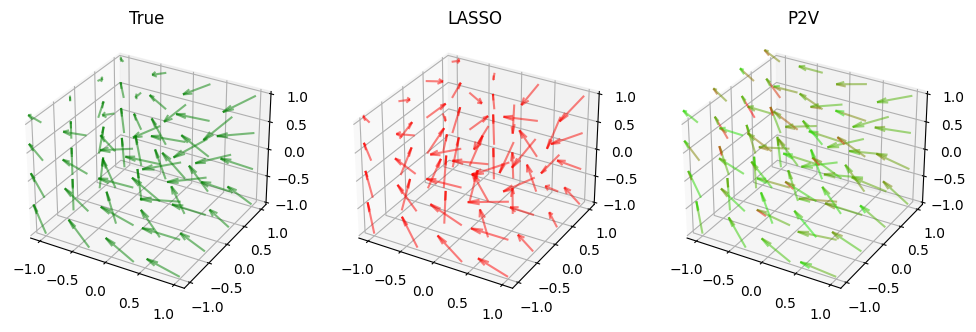

In [32]:
import matplotlib.pyplot as plt

vis_ind = np.random.permutation(len(all_pars_fit_p2v))[0]
lattice_step = 8
x,y,z = np.meshgrid(np.linspace(-1,1,int(num_lattice/lattice_step)),
                    np.linspace(-1,1,int(num_lattice/lattice_step)),
                    np.linspace(-1,1,int(num_lattice/lattice_step)))
fig, axes = plt.subplots(1,3,subplot_kw=dict(projection='3d'), figsize=(12,4))

vfs = [vf[:,::lattice_step,::lattice_step,::lattice_step] for vf in [sorted_data[vis_ind],all_recons_lasso[vis_ind], all_recons_p2v[vis_ind]]]

arrow_colors = []
for vf in vfs:
    per_site_loss = euclidean(torch.tensor(vf),vfs[0],reduce=False).mean(0).numpy()
    per_site_loss /= per_site_loss.max()
    color = np.array([per_site_loss, 1-per_site_loss, np.zeros_like(per_site_loss)])
    arrow_colors.append(color)
    
print(test_system_classes[np.sort(y_test)[vis_ind]]) 
for i, (nm, ax, vf,color) in enumerate(zip(['True','LASSO', 'P2V'],axes,vfs,arrow_colors)):
    vf_norm = np.sqrt((vf**2).sum(0))
    normed_vf = .5*vf/vf_norm

    arrow_color = color.reshape(3,-1).T if i > 0 else 'g'
    ax.quiver(x,y,z,normed_vf[0],normed_vf[1],normed_vf[2],alpha=.5,color=arrow_color)
    ax.set_title(nm)

plt.show()
plt.close()